In [62]:
import os
import keras
from keras import layers
from keras.datasets import mnist
from keras.utils import plot_model
from keras.models import load_model
from keras import regularizers
from keras.losses import mse, binary_crossentropy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

*Let's prepare out input data first. We will normalize all the values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.*

In [2]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

# normalizing the values between 0 and 1
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# Converting to 1D Array (Vector respresentation)
x_train = x_train.reshape(-1, np.prod(x_train.shape[1:]))
x_test = x_test.reshape(-1, np.prod(x_test.shape[1:]))

In [76]:
# mapping inputs to our latent representations

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

# using these parameters to sample new similar points from latent space

from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

# mapping these sampled points back to reconstructed inputs

# Create encoder
# encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder = keras.Model(inputs, z, name='encoder')
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
# x = layers.Dense(intermediate_dim, activation='relu')(z)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
# outputs = decoder(encoder(inputs)[2])
outputs = decoder(encoder(inputs))
vae = keras.Model(inputs, outputs, name='vae_mlp')

# custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.fit(x_train,
        epochs=100,
        batch_size=256,
        shuffle = True,
        validation_data = (x_test,None))

# vae.save('./models/vae.h5')
# encoder.save('./models/vae_encoder.h5')
# decoder.save('./models/vae_decoder.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 32us/step - loss: 71.0339 - val_loss: 49.4306
Epoch 2/100
60000/60000 [==============================] - 2s 29us/step - loss: 46.9880 - val_loss: 45.1901
Epoch 3/100
60000/60000 [==============================] - 2s 26us/step - loss: 43.9611 - val_loss: 42.8295
Epoch 4/100
60000/60000 [==============================] - 2s 26us/step - loss: 42.4621 - val_loss: 41.8256
Epoch 5/100
60000/60000 [==============================] - 2s 26us/step - loss: 41.6678 - val_loss: 41.1716
Epoch 6/100
60000/60000 [==============================] - 2s 26us/step - loss: 41.0949 - val_loss: 40.6804
Epoch 7/100
60000/60000 [==============================] - 2s 27us/step - loss: 40.6225 - val_loss: 40.2351
Epoch 8/100
60000/60000 [==============================] - 2s 31us/step - loss: 40.2022 - val_loss: 39.8864
Epoch 9/100
60000/60000 [==============================] - 2s 31us/step - loss: 39.820

60000/60000 [==============================] - 2s 26us/step - loss: 34.1674 - val_loss: 34.6664
Epoch 76/100
60000/60000 [==============================] - 2s 26us/step - loss: 34.1387 - val_loss: 34.6081
Epoch 77/100
60000/60000 [==============================] - 2s 26us/step - loss: 34.1246 - val_loss: 34.5741
Epoch 78/100
60000/60000 [==============================] - 2s 26us/step - loss: 34.0974 - val_loss: 34.5851
Epoch 79/100
60000/60000 [==============================] - 2s 26us/step - loss: 34.0773 - val_loss: 34.6206
Epoch 80/100
60000/60000 [==============================] - 2s 26us/step - loss: 34.0672 - val_loss: 34.5614
Epoch 81/100
60000/60000 [==============================] - 2s 26us/step - loss: 34.0423 - val_loss: 34.5414
Epoch 82/100
60000/60000 [==============================] - 2s 26us/step - loss: 34.0181 - val_loss: 34.5573
Epoch 83/100
60000/60000 [==============================] - 2s 26us/step - loss: 33.9997 - val_loss: 34.5000
Epoch 84/100
60000/60000 [======

In [77]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

<IPython.core.display.Javascript object>


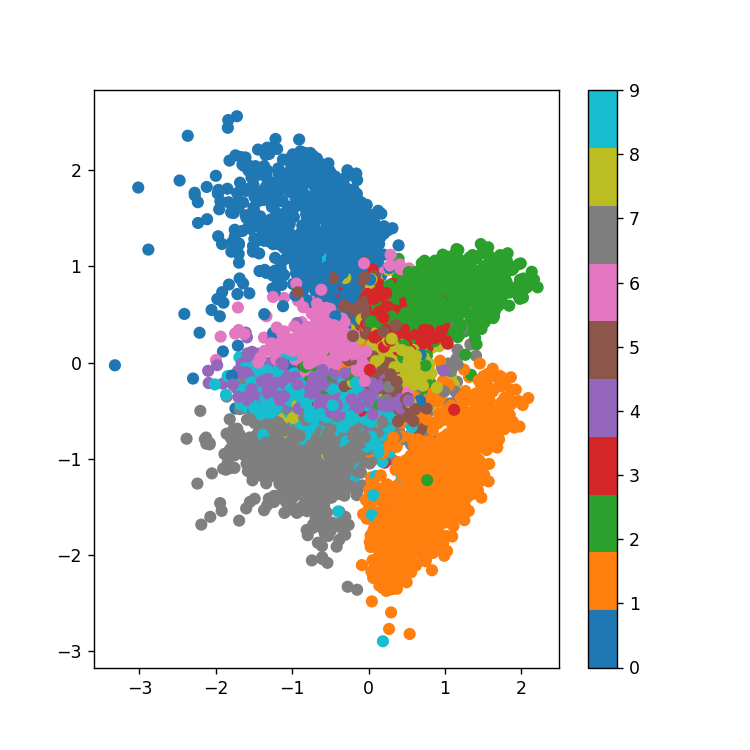

In [78]:
# display a 2D plot of the digit classes in the latent space
# x_test_encoded = np.array(encoder.predict(x_test, batch_size=256))
plt.figure(figsize=(6, 6))
plt.scatter(encoded_imgs[:,0], encoded_imgs[:,1], c=y_test, cmap ='tab10')
plt.colorbar()
plt.show()

***Each of these colored coded cluster is a type of a digit. Close clusters are digits that are structurally similar i.e. digits share information in the latent space.***

<IPython.core.display.Javascript object>


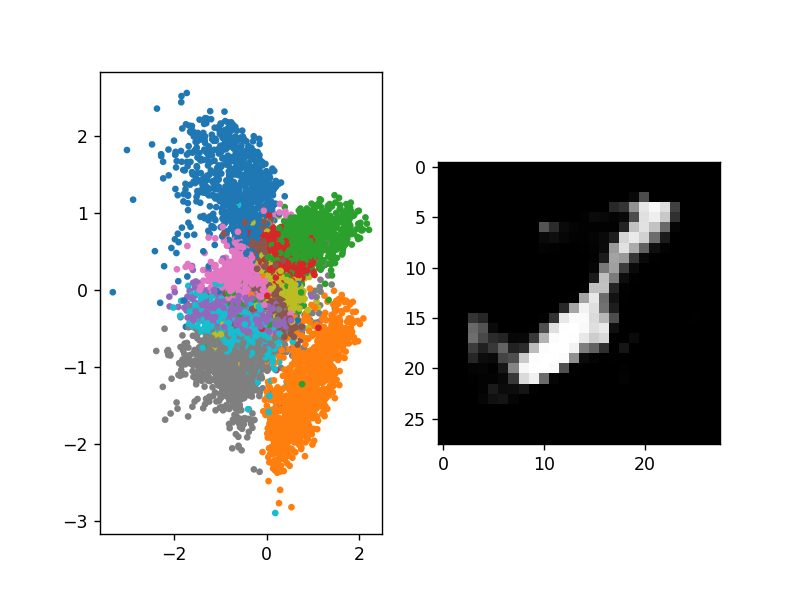

In [84]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(x=encoded_imgs[:,0],y=encoded_imgs[:,1], c = y_test, s =8, cmap='tab10')

def onclick(event):
#     global flag
    ix, iy = event.xdata, event.ydata
    latent_vector = np.array([[ix, iy]])
    
    decoded_img = decoder.predict(latent_vector)
    decoded_img = decoded_img.reshape(28, 28)
    ax[1].imshow(decoded_img, cmap='gray')
    plt.draw()

# motion_notify_event
cid = fig.canvas.mpl_connect('motion_notify_event', onclick)
plt.show()